Running inference on image pairs
============================

If you want to use a pre-trained PWC-Net model on your own set of images, you can pass a list of image pairs to a `ModelPWCNet` object using its  `predict_from_img_pairs()` method, as demonstrated here.

Below, look for `TODO` references and customize this notebook based on your own needs.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
!nvidia-smi

Wed Apr 24 11:25:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.40.04    Driver Version: 418.40.04    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P40           Off  | 00000000:0D:00.0 Off |                  Off |
| N/A   50C    P0   172W / 250W |   8699MiB / 24451MiB |     90%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P40           Off  | 00000000:0E:00.0 Off |                  Off |
| N/A   39C    P0    55W / 250W |  16671MiB / 24451MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [3]:
"""
pwcnet_predict_from_img_pairs.ipynb

Run inference on a list of images pairs.

Written by Phil Ferriere

Licensed under the MIT License (see LICENSE for details)
"""
from __future__ import absolute_import, division, print_function
from copy import deepcopy
from skimage.io import imread
from model_pwcnet import ModelPWCNet, _DEFAULT_PWCNET_TEST_OPTIONS
from visualize import display_img_pairs_w_flows

In [4]:
# TODO: Set device to use for inference
# Here, we're using a GPU (use '/device:CPU:0' to run inference on the CPU)
gpu_devices = ['/device:GPU:1']  
controller = '/device:GPU:1'

# TODO: Set the path to the trained model (make sure you've downloaded it first from http://bit.ly/tfoptflow)
ckpt_path = './models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000'

In [ ]:
import cv2

In [6]:
nn_opts = deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# We're running the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
nn_opts['adapt_info'] = (1, 375, 1242, 2)

In [7]:
nn = ModelPWCNet(mode='test', options=nn_opts)
nn.print_config()

Building model...
... model built.
Loading model checkpoint ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:1']
  controller             /device:GPU:1
  batch_size             1
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  adapt_info             (1, 375, 1242, 2)
  mode                   test
  trainable para

In [33]:
# Build a list of image pairs to process
img_pairs = []
for i in range(0,9):
    image_path1 = './samples/02/00000{}.png'.format(i)
    image_path2 = './samples/02/00000{}.png'.format(i+1)
    image1, image2 = imread(image_path1), imread(image_path2)
    img_pairs.append((image1, image2))

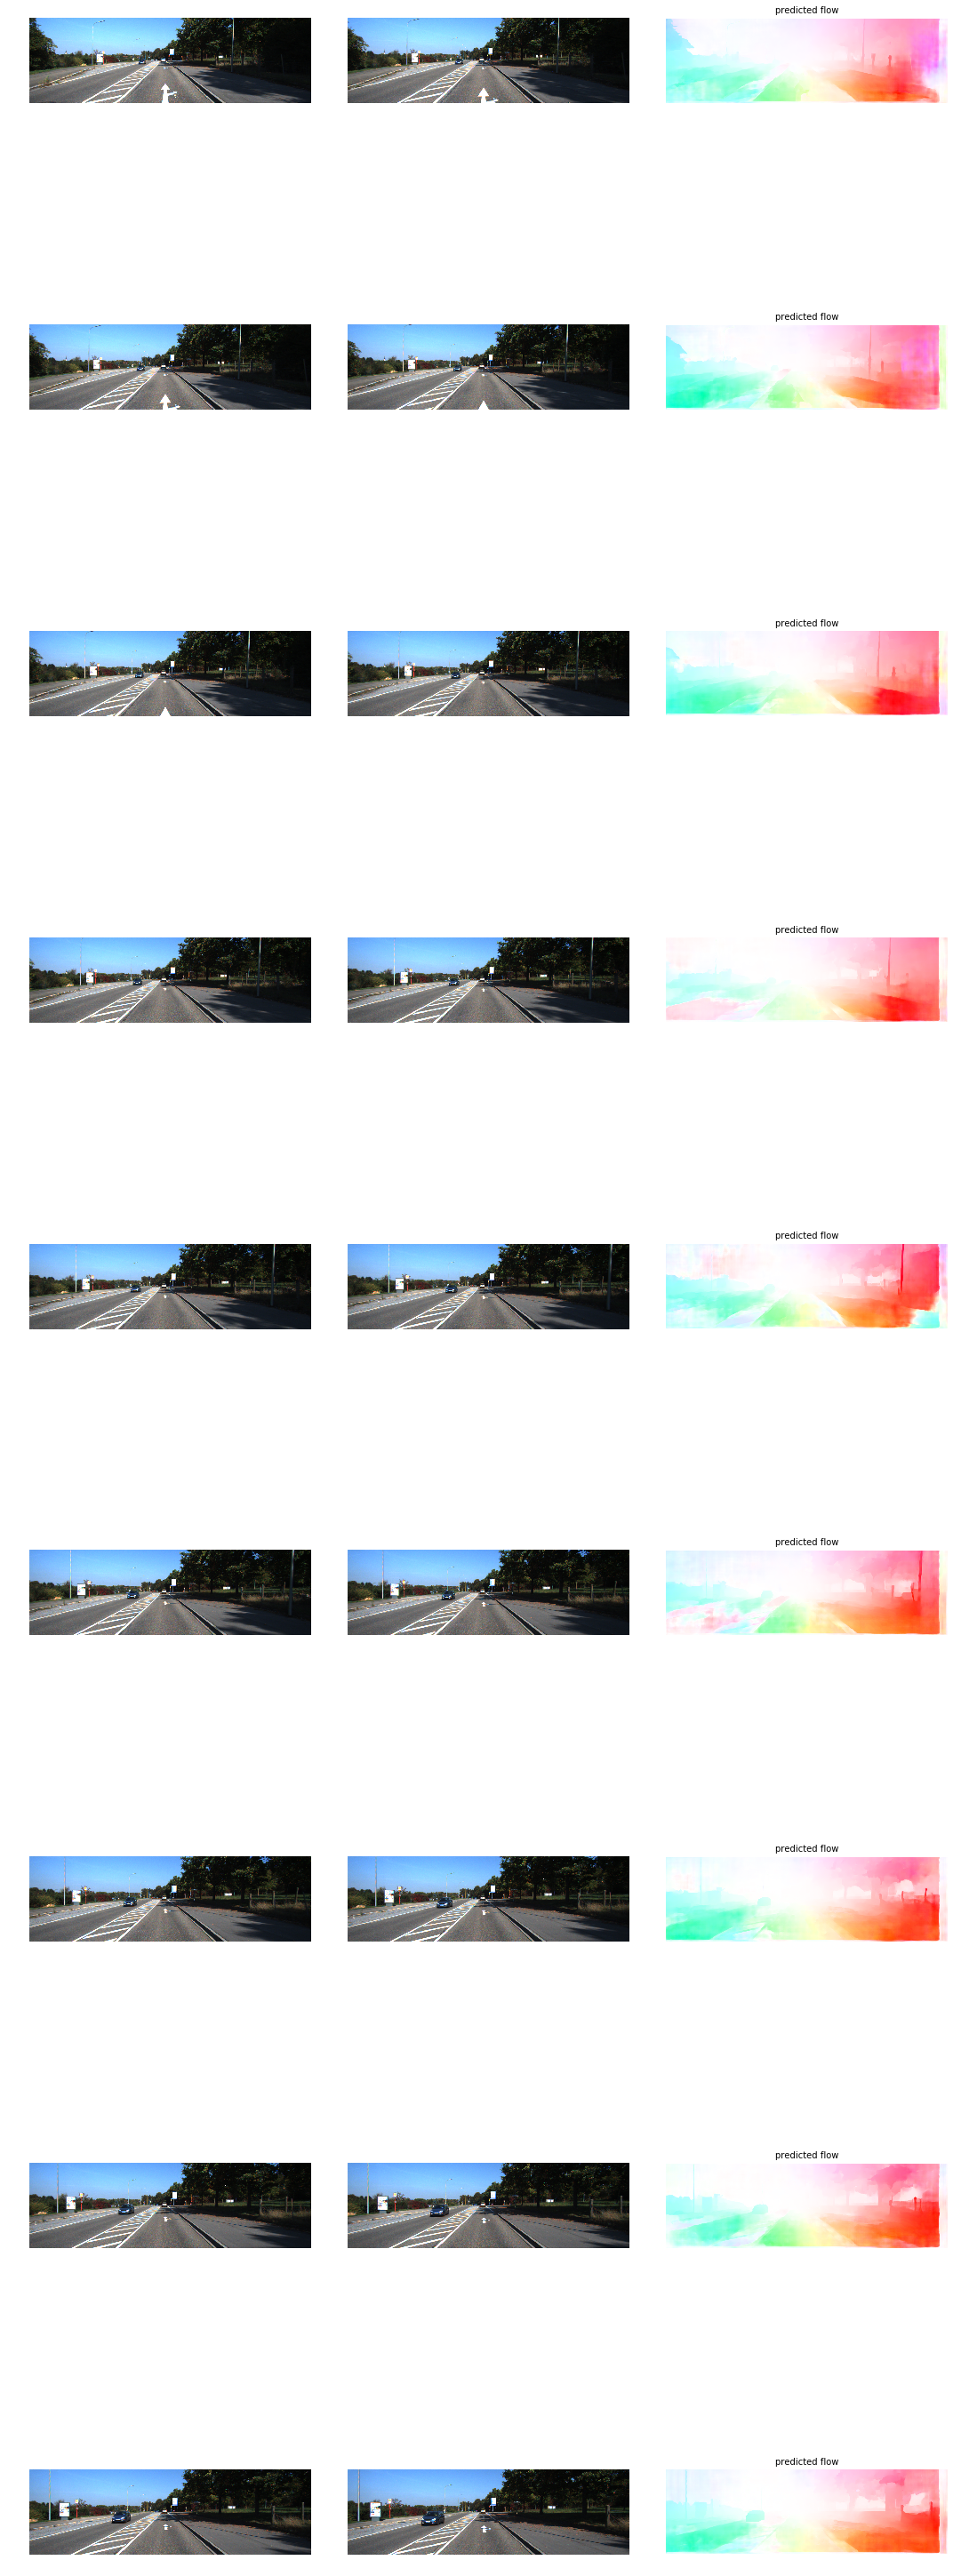

In [34]:
pred_labels = nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)
display_img_pairs_w_flows(img_pairs, pred_labels)

In [9]:
pred_labels[0].shape

(96, 320, 2)

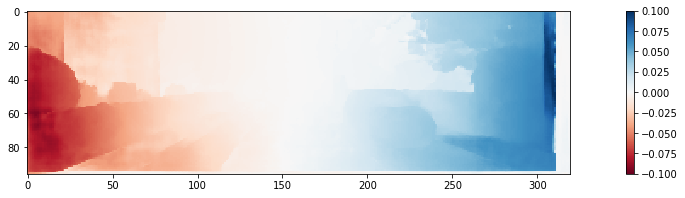

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(pred_labels[0][:,:,0]/320, cmap='RdBu', vmin= -0.1, vmax=0.1 )
plt.colorbar()

In [19]:
import numpy as np
flow = np.load('/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/03/optical_flow_pwc_skip1_normalized/000000_000001.npy')

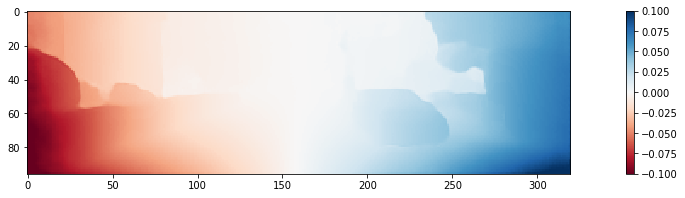

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(flow[:,:,0], cmap='RdBu', vmin= -0.1, vmax=0.1)
plt.colorbar()

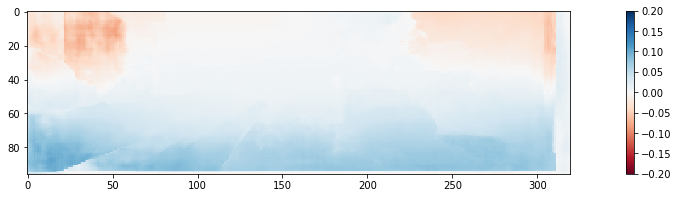

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(pred_labels[0][:,:,0]/320, cmap='RdBu', vmin= -0.2, vmax=0.2)
plt.colorbar()

In [28]:
import numpy as np
flow = np.load('/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000004_000005.npy')

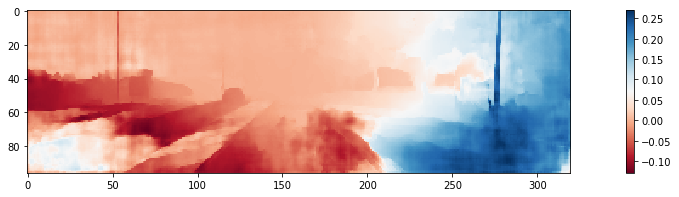

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(flow[:,:,0], cmap='RdBu')
plt.colorbar()

In [37]:
import glob 

# добавляем колонки

In [35]:
def get_image_number(line):
    return line.split("/")[-1][:-len('.jpg')]


def read_rgb_flow_from_csv(path, stride=1, type_flow="gt"):
    df = pd.read_csv(os.path.join(path, "df.csv".format(stride)), index_col=0)
    path_to_second_rgb = df[["path_to_next_rgb"]].values
    path_to_first_rgb = df[["path_to_rgb"]].values
    path_to_flow = df[["optical_flow_{}_skip{}_lg".format(type_flow, stride)]].values
    return np.hstack([path_to_first_rgb, path_to_second_rgb, path_to_flow])

def update_csv_of(path, filename, stride, additonal_path=''):
    df = pd.read_csv(str(path) + str(additonal_path)+ str(filename), index_col=0)
    df.insert(13, 'optical_flow_pwc_skip1_torch_chairs'.format(str(stride)), ' ')
    for  (id1, row1) in df.iterrows():
        rgb1 = row1.path_to_rgb
        rgb2 = row1.path_to_next_rgb
        df.at[id1,'optical_flow_pwc_skip1_torch_chairs'.format(str(stride))]= 'optical_flow_pwc_skip1_torch_chairs/{}_{}.npy'.format(get_image_number(rgb1),get_image_number(rgb2))
    df.to_csv(str(path) + '/' + str(filename))



In [38]:
import os
import pandas as pd
path = '/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/'
allfolders = glob.glob( path +"/*")
for i in allfolders:
    print(i)
    if os.path.isfile( i + "/df.csv"):
        update_csv_of(i,"/df.csv", 1)

/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/05
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/08
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/21
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/11
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/19
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/14
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/17
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/01
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/09
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/04
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/07
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/13
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/16
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/00
/Vol1/dbstore/datasets/KITTI_odometry_20

# Сетка для КИТТИ

In [99]:
# Configure the model for inference, starting with the default options
nn_opts = deepcopy(_DEFAULT_PWCNET_TEST_OPTIONS)
nn_opts['verbose'] = True
nn_opts['ckpt_path'] = ckpt_path
nn_opts['batch_size'] = 1
nn_opts['gpu_devices'] = gpu_devices
nn_opts['controller'] = controller

# We're running the PWC-Net-large model in quarter-resolution mode
# That is, with a 6 level pyramid, and upsampling of level 2 by 4 in each dimension as the final flow prediction
nn_opts['use_dense_cx'] = True
nn_opts['use_res_cx'] = True
nn_opts['pyr_lvls'] = 6
nn_opts['flow_pred_lvl'] = 2

# The size of the images in this dataset are not multiples of 64, while the model generates flows padded to multiples
# of 64. Hence, we need to crop the predicted flows to their original size
nn_opts['adapt_info'] = (1, 375, 1242, 2)

In [100]:
nn = ModelPWCNet(mode='test', options=nn_opts)
nn.print_config()

Building model...
... model built.
Loading model checkpoint ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000 for eval or testing...

INFO:tensorflow:Restoring parameters from ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
... model loaded

Model Configuration:
  verbose                True
  ckpt_path              ./models/pwcnet-lg-6-2-multisteps-chairsthingsmix/pwcnet.ckpt-595000
  x_dtype                <dtype: 'float32'>
  x_shape                [2, None, None, 3]
  y_dtype                <dtype: 'float32'>
  y_shape                [None, None, 2]
  gpu_devices            ['/device:GPU:0']
  controller             /device:GPU:0
  batch_size             1
  use_tf_data            True
  use_mixed_precision    False
  pyr_lvls               6
  flow_pred_lvl          2
  search_range           4
  use_dense_cx           True
  use_res_cx             True
  adapt_info             (1, 375, 1242, 2)
  mode                   test
  trainable para

# Скрипт

In [115]:
from math import ceil
import cv2
def create_of(path, path_to_save):
    img_pairs=[]
    stride=1
    path_list = read_rgb_flow_from_csv(path, stride, type_flow='pwc')
    for i in path_list:
        img_pairs=[]
        prev_img = None
        im1_fn = path + str(i[0])
        im2_fn = path + str(i[1])
        flow_fn = path + str(i[2])
        print('created', i)
        if not os.path.isfile(flow_fn):
            #print(i, flow_fn)              
            #im_all = [imread(im1_fn) if prev_img is None else prev_img, imread(im2_fn)]
            #im_all = [im[:, :, :3] for im in im_all]
            image1, image2 = imread(im1_fn), imread(im2_fn)
            divisor = 64.
            H = image1.shape[0]
            W = image1.shape[1]
            #print(H, W)
            H_ = int(ceil(H / divisor) * divisor)
            W_ = int(ceil(W / divisor) * divisor)
            image1 = cv2.resize(image1, ( W_, H_))
            image2 = cv2.resize(image2, ( W_, H_))
            img_pairs.append((image1, image2))

            nn.predict_from_img_pairs_save(img_pairs, flow_fn,  batch_size=1, verbose=False)

# Запуск

In [116]:
import os
import pandas as pd
import numpy as np

path = '/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/'
allfolders = glob.glob( path +"/*/")
#list_temp = []
path_to_save = "/optical_flow_pwc_skip1_lg"
for i in allfolders:
    #print(i)
    if os.path.isfile( i +  "/df.csv"):
        #if not os.path.exists(i +  path_to_save):
        #    os.makedirs(i + path_to_save)
        create_of(i, path_to_save)

        
        #nn.predict_from_img_pairs(img_pairs, batch_size=1, verbose=False)

created ['image_2/000000.png' 'image_2/000001.png'
 'optical_flow_pwc_skip1_lg/000000_000001.npy']
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000000_000001.npy
created ['image_2/000001.png' 'image_2/000002.png'
 'optical_flow_pwc_skip1_lg/000001_000002.npy']
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000001_000002.npy
created ['image_2/000002.png' 'image_2/000003.png'
 'optical_flow_pwc_skip1_lg/000002_000003.npy']
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000002_000003.npy
created ['image_2/000003.png' 'image_2/000004.png'
 'optical_flow_pwc_skip1_lg/000003_000004.npy']
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000003_000004.npy
created ['image_2/000004.png' 'image_2/000005.png'
 'optical_flow_pwc_skip1_lg/000004_000005.npy']
/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_f

KeyboardInterrupt: 

In [123]:
flow = np.load('/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_lg/000004_000005.npy')

# Дальше проверки, не интересно

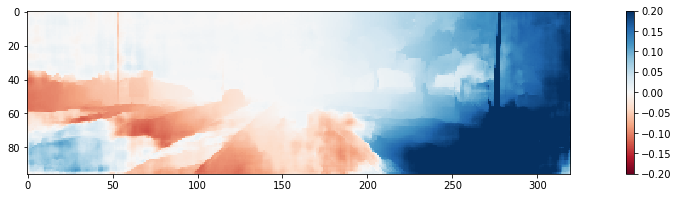

In [124]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(flow[:,:,0], cmap='RdBu', vmin= -0.2, vmax=0.2)
plt.colorbar()

In [125]:
flow = np.load('/Vol1/dbstore/datasets/KITTI_odometry_2012/dataset/sequences/02/optical_flow_pwc_skip1_normalized/000004_000005.npy')

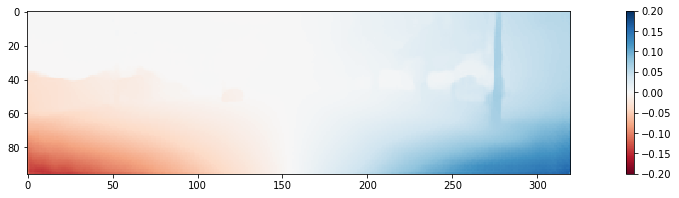

In [126]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,3))
plt.imshow(flow[:,:,0], cmap='RdBu', vmin= -0.2, vmax=0.2)
plt.colorbar()

In [76]:
flow.shape

(96, 320, 2)

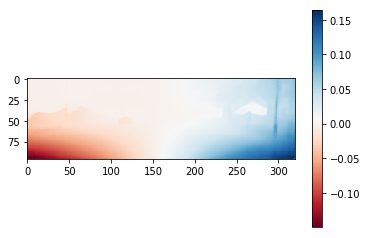

In [87]:
import matplotlib.pyplot as plt
plt.imshow(flow[:,:,0], cmap='RdBu')
plt.colorbar()